# Computational Social Science: Text Preprocessing and Featurization

This lab will cover the basics of text preprocessing and featurization, and introduce text classification.

In [1]:
import spacy
import en_core_web_sm
import pandas as pd
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import train_test_split
import numpy as np
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sn
%matplotlib inline

## Data

<img src = "../images/cfpb logo.png"  />

For the next few labs, we will use the COnsumer Financial Protection Bureau's [Consumer Complaint Database](https://www.consumerfinance.gov/data-research/consumer-complaints/). The database is rich with information about individual consumer complaints about credit card fraud, debt collections, and other consumer issues.

In [2]:
cfpb = pd.read_csv("../data/CFPB 2020 Complaints.csv")
cfpb = cfpb.dropna(subset = ['Consumer complaint narrative']).reset_index()

In [3]:
cfpb.head()

,index,Date received,Product,Sub-product,Issue,Sub-issue,Consumer complaint narrative,Company public response,Company,State,ZIP code,Tags,Consumer consent provided?,Submitted via,Date sent to company,Company response to consumer,Timely response?,Consumer disputed?,Complaint ID
0,8,01/30/20,"Credit reporting, credit repair services, or o...",Credit reporting,Problem with a credit reporting company's inve...,Investigation took more than 30 days,Reviewed my credit report in XX/XX/XXXX and no...,None,"EQUIFAX, INC.",AZ,850XX,None,Consent provided,Web,01/30/20,Closed with explanation,Yes,NaN,3515096
1,10,03/12/20,"Credit reporting, credit repair services, or o...",Credit reporting,Incorrect information on your report,Account status incorrect,TransUnion has not properly investigated the i...,Company has responded to the consumer and the ...,"TRANSUNION INTERMEDIATE HOLDINGS, INC.",IL,606XX,None,Consent provided,Web,03/12/20,Closed with explanation,Yes,NaN,3564439
2,14,05/01/20,"Credit reporting, credit repair services, or o...",Credit reporting,Problem with a credit reporting company's inve...,Their investigation did not fix an error on yo...,XX/XX/2020 someone tried to steal my identity ...,Company has responded to the consumer and the ...,"TRANSUNION INTERMEDIATE HOLDINGS, INC.",IL,606XX,None,Consent provided,Web,05/01/20,Closed with non-monetary relief,Yes,NaN,3633318
3,19,04/06/20,Debt collection,Other debt,Attempts to collect debt not owed,Debt was paid,I paid the debt on XX/XX/XXXX. I disputed acco...,Company has responded to the consumer and the ...,Experian Information Solutions Inc.,NY,None,Servicemember,Consent provided,Web,04/06/20,Closed with explanation,Yes,NaN,3594679
4,35,04/18/20,Debt collection,I do not know,Attempts to collect debt not owed,Debt is not yours,A COLLECTION HAS BEEN REPORTED TO MY CREDIT RE...,Company has responded to the consumer and the ...,"Convergent Resources, Inc.",FL,336XX,None,Consent provided,Web,04/18/20,Closed with explanation,Yes,NaN,3611900


## Tokenization

Tokenization is the **process of splitting text into words and sentences.** These chunks (words, sentences, etc.) are called **tokens**. One approach might be to try to do this use string methods like [str.split](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.Series.str.split.html). The problem with this is that using a separator like a "," or "." or " " may not work for some common situations. So instead, we'll use the [spaCy](https://spacy.io/) library.

### Why tokenize?

Electronic text is a linear sequence of symbols. Before any processing is to be done, text needs to be segmented into linguistic units, and this process is called tokenization.

We usually look at grammar and meaning at the level of words, related to each other within sentences, within each document. So if we're starting with raw text, we first need to split the text into sentences, and those sentences into words -- which we call "tokens".

### How to tokenize

#### Using String Methods

##### Split Into Sentences

You might imagine that the easiest way to identify sentences is to split the document at every period '.', and to split the sentences using white space to get the words.

In [4]:
# using the split function to create tokens
text = cfpb['Consumer complaint narrative'][0]
paragraph = text
sentences = paragraph.split(".")
for s in sentences[:5]:
    print(s + '\n')

Reviewed my credit report in XX/XX/XXXX and noticed a lot of errors, inconsistent, and incorrect information

 Sent a letter to Equifax on XX/XX/XXXX via mail asking them for an investigation and to verify all the dates and amounts were correct and fix the incorrect reporting on my credit

 They did not respond at all so I sent another letter on XX/XX/XXXX via mail, again asking for an investigation and proof

 They still didnt respond to that letter so I sent a third letter on XX/XX/XXXX certified mail so I have proof that they signed for my letter



Last week I received two letters from Equifax dated XX/XX/XXXX on the same day



##### Split Into Tokens
From here, we might split each sentence into tokens by splitting on white space in between words. Try filling in the code below to take the first sentence and split on white spaces.

In [5]:
sentence = sentences[0]
tokens = sentence.split(" ")
tokens

['Reviewed',
 'my',
 'credit',
 'report',
 'in',
 'XX/XX/XXXX',
 'and',
 'noticed',
 'a',
 'lot',
 'of',
 'errors,',
 'inconsistent,',
 'and',
 'incorrect',
 'information']

##### Challenge 1: What was the problem with splitting on the white space? Are there any tokens that look a little strange?

**Answer**: We may not want some words to have commas after them like "errors," and "inconsistent,"

#### spaCy

In contrast to string methods, spaCy uses pre-trained language models to incorporate context. In this case, we'll load the [en_core_web_sm](https://spacy.io/models/en), which is one of spaCy's English language models. For instance, the end of a sentence (".") should mark a new token, but the string "U.K." should not be separated at the "."'s. According to [spaCy's documentation](https://spacy.io/usage/spacy-101#annotations-token) it achieves this by taking the following steps:

First, the raw text is split on whitespace characters, similar to text.split(' '). Then, the tokenizer processes the text from left to right. On each substring, it performs two checks:

1. Does the substring match a tokenizer exception rule? For example, “don’t” does not contain whitespace, but should be split into two tokens, “do” and “n’t”, while “U.K.” should always remain one token.
2. Can a prefix, suffix or infix be split off? For example punctuation like commas, periods, hyphens or quotes.

If there’s a match, the rule is applied and the tokenizer continues its loop, starting with the newly split substrings. This way, spaCy can split complex, nested tokens like combinations of abbreviations and multiple punctuation marks.

Now let's try applying these methods to our CFPB data. The steps to do this are:

1. Load the language model.
2. Apply it to a piece of text and save it in an spaCy "doc" object.
3. Extract each token from the doc object to a list.
4. Display the tokens

Check the documentation for help filling in these steps!

In [6]:
nlp = en_core_web_sm.load()

doc = nlp(text)
spacy_words = [token.text for token in doc]
display(f"Tokenized words: {spacy_words}")

I0602 17:04:35.801137 10848 file_utils.py:39] PyTorch version 1.2.0 available.
I0602 17:04:36.029167 10848 modeling_xlnet.py:194] Better speed can be achieved with apex installed from https://www.github.com/nvidia/apex .


"Tokenized words: ['Reviewed', 'my', 'credit', 'report', 'in', 'XX', '/', 'XX', '/', 'XXXX', 'and', 'noticed', 'a', 'lot', 'of', 'errors', ',', 'inconsistent', ',', 'and', 'incorrect', 'information', '.', 'Sent', 'a', 'letter', 'to', 'Equifax', 'on', 'XX', '/', 'XX', '/', 'XXXX', 'via', 'mail', 'asking', 'them', 'for', 'an', 'investigation', 'and', 'to', 'verify', 'all', 'the', 'dates', 'and', 'amounts', 'were', 'correct', 'and', 'fix', 'the', 'incorrect', 'reporting', 'on', 'my', 'credit', '.', 'They', 'did', 'not', 'respond', 'at', 'all', 'so', 'I', 'sent', 'another', 'letter', 'on', 'XX', '/', 'XX', '/', 'XXXX', 'via', 'mail', ',', 'again', 'asking', 'for', 'an', 'investigation', 'and', 'proof', '.', 'They', 'still', 'did', 'nt', 'respond', 'to', 'that', 'letter', 'so', 'I', 'sent', 'a', 'third', 'letter', 'on', 'XX', '/', 'XX', '/', 'XXXX', 'certified', 'mail', 'so', 'I', 'have', 'proof', 'that', 'they', 'signed', 'for', 'my', 'letter', '.', '\\n\\n', 'Last', 'week', 'I', 'received

#### Removing Stop Words and Punctuation

We now have some tokens with just a few lines of code! There are a few additional steps that we might want to take. For example, we may want to remove punctuation and stop words. Punctuation oftentimes does not add substantive information to a piece of text, and stop words are common words that appear very frequently across texts. Removing this kind of information can help with downstream classification tasks by allowing an algorithm to focus on words that distinguish documents, rather than ones that appear frequently across them. 

First, let's take a look at stop words. We can start by importing a collection of stop words from spaCy by running the following code:

In [7]:
from spacy.lang.en.stop_words import STOP_WORDS

Now let's look at some common stop words from this collection:

In [8]:
list(STOP_WORDS)[0:10]

['you',
 'becoming',
 'next',
 'none',
 'along',
 'seeming',
 'than',
 'give',
 'using',
 'get']

We can do the same for punctuation:

In [9]:
from string import punctuation
punctuation

'!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

Removing punctuation and stop words is not a hard and fast rule - there may be situations where you want to keep them. In most applications, they add noise to downstream tasks, but always be mindful of your particular application when making decisions. Now that we have some tokenization tools, let's put them all together in a function!

##### Challenge 2: Write a function that takes a piece of text as an argument, and returns a list of tokens without punctuation or stop words.

In [10]:
tokens_reduced = []

def rem_punc_stop(text):
    stop_words = STOP_WORDS
    punc = set(punctuation)
    
    punc_free = "".join([ch for ch in text if ch not in punc])
    
    doc = nlp(punc_free)
    
    spacy_words = [token.text for token in doc]
    
    no_punc = [word for word in spacy_words if word not in stop_words]
    
    return no_punc

In [11]:
tokens_reduced = rem_punc_stop(text)
tokens_reduced[0:5]

['Reviewed', 'credit', 'report', 'XXXXXXXX', 'noticed']

## Entity Recognition

spaCy also contains a number of methods for things like entity recognition. For instance, we could run the following code to check various entities. Notice that this process isn't perfect, spaCy still thinks "XX/XX/XXXX" is an organization or product even though we know this is a redacted date.

In [12]:
for entity in nlp(text).ents:
    print(entity.text + ' - ' + entity.label_ + ' - ' + str(spacy.explain(entity.label_)))

XX/XX/XXXX - ORG - Companies, agencies, institutions, etc.
Equifax - PERSON - People, including fictional
XX/XX/XXXX - ORG - Companies, agencies, institutions, etc.
third - ORDINAL - "first", "second", etc.
XX/XX/XXXX - ORG - Companies, agencies, institutions, etc.
Last week - DATE - Absolute or relative dates or periods
two - CARDINAL - Numerals that do not fall under another type
Equifax - PERSON - People, including fictional
XX/XX/XXXX - PRODUCT - Objects, vehicles, foods, etc. (not services)
the same day - DATE - Absolute or relative dates or periods
three - CARDINAL - Numerals that do not fall under another type
Arizona - GPE - Countries, cities, states
second - ORDINAL - "first", "second", etc.


## Lemmatization

Another preprocessing step we might take is reducing words down to their lemmas. Lemmatization reduces a word to its root word, while making sure the word still belongs to the language. This is in contrast to stemming, which reduces the word down to its root even if that root is not a valid word. Consider the following example:

In [13]:
for word in nlp(u'compute computer computed computing'):
    print(word.text,  word.lemma_)

compute compute
computer computer
computed compute
computing computing


Stemming these words would all result in the root "comput" but lemmatization converted these words to their shortest variant. Again, you may choose to stem or lemmatize depending on your specific application.

##### Challenge 3: Lemmatize the first consumer complaint narrative:

In [14]:
for word in nlp(text):
    print(word.text,  word.lemma_)

Reviewed reviewed
my -PRON-
credit credit
report report
in in
XX XX
/ /
XX XX
/ /
XXXX XXXX
and and
noticed notice
a a
lot lot
of of
errors error
, ,
inconsistent inconsistent
, ,
and and
incorrect incorrect
information information
. .
Sent send
a a
letter letter
to to
Equifax Equifax
on on
XX XX
/ /
XX XX
/ /
XXXX xxxx
via via
mail mail
asking ask
them -PRON-
for for
an an
investigation investigation
and and
to to
verify verify
all all
the the
dates date
and and
amounts amount
were be
correct correct
and and
fix fix
the the
incorrect incorrect
reporting reporting
on on
my -PRON-
credit credit
. .
They -PRON-
did do
not not
respond respond
at at
all all
so so
I -PRON-
sent send
another another
letter letter
on on
XX XX
/ /
XX XX
/ /
XXXX xxxx
via via
mail mail
, ,
again again
asking ask
for for
an an
investigation investigation
and and
proof proof
. .
They -PRON-
still still
did do
nt not
respond respond
to to
that that
letter letter
so so
I -PRON-
sent send
a a
third third
letter lett

## Chunking

We may also want to chunk more than one word together. One way to do this might be to group nounds together. 

**Challenge 4: Trying using the "noun_chunks" method to chunk nouns in the first complaint.**

In [15]:
doc = nlp(text)
for np in doc.noun_chunks:
    print(np.text)

my credit report
XX/XX/XXXX
a lot
errors
incorrect information
a letter
Equifax
XX/XX/XXXX
mail
them
an investigation
all the dates
amounts
the incorrect reporting
my credit
They
I
another letter
XX/XX/XXXX
mail
an investigation
proof
They
that letter
I
a third letter
XX/XX/XXXX certified mail
I
proof
they
my letter
I
two letters
Equifax
XX/XX/XXXX
the same day
they
my credit file
me
proof
identification
address
all three letters
I
a copy
my Arizona drivers license
my XXXX direct deposit sub
my proof
address
The second letter
they
my request
it
my credit file
they
my file
the restriction
they
my credit file
regards
investigation purposes


## Bag of Words

Now that we have covered some the basics of text preprocessing, we are ready to start getting our data in a format for feeding it into machine learning algorithms. There are many options for converting raw text to features in a supervised machine learning problem. The most basic of these is the "bag of words" approach. Bag of words essentially counts the number of times each word appears in a corpus, and these counts become features.

To illustrate, first let's import the CounterVectorizer method from sklearn. Once we do that, let's use our tokenizer function that we wrote earlier to initialize the CountVectorizer.

In [16]:
from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer

In [17]:
bow_vector = CountVectorizer(tokenizer = rem_punc_stop, ngram_range=(1,1))

Once we create a CountVectorizer object, we can then transform a list of texts with the "fit_transform" method. This will return a sparse matrix with the counts. We can densify the matrix with the ".todense()" method.

In [18]:
bow_matrix = bow_vector.fit_transform(cfpb['Consumer complaint narrative'][0:5])

In [19]:
bow_matrix.todense()

matrix([[ 0,  1,  0,  0,  0,  1,  1,  2,  1,  1,  2,  0,  0,  1,  0,  0,
          0,  1,  1,  5,  1,  1,  1,  0,  1,  1,  0,  0,  0,  1,  2,  1,
          4,  0,  2,  1,  0,  0,  1,  0,  1,  2,  1,  0,  0,  3,  0,  6,
          2,  1,  1,  1,  1,  3,  1,  1,  2,  0,  0,  0,  0,  1,  4,  0,
          1,  0,  2,  0,  1,  0,  1,  1,  0,  1,  1,  0,  2,  1,  0,  1,
          2,  1,  1,  4,  0,  1,  0,  0,  1,  0,  0,  0,  0,  0,  0,  1,
          1,  1,  0,  0,  5],
        [ 0,  1,  2,  0,  1,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
          0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
          0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  1,  0,  1,  0,
          0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  1,  0,  0,  0,  1,
          0,  0,  0,  0,  0,  0,  1,  1,  0,  0,  0,  1,  0,  0,  1,  0,
          0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  1,  1,  0,  7,  0,
          0, 26,  7,  0,  0],
        [ 1,  0,  4,  0,  0,  0,  0,  0,  0,  0,  0,  0,  1,  0,

We can also get the feature names:

In [20]:
feature_names = bow_vector.get_feature_names()
feature_names[0:10]

['\n',
 '\n\n',
 ' ',
 'account',
 'accounts',
 'add',
 'added',
 'address',
 'amounts',
 'arizona']

## Term Frequency - Inverse Document Frequency

An extension of bag-of-words is the term frequency-inverse document frequency approach. Whereas bag-of-words counts the number of words in the document. tf-idf takes this quanity and divides it by how frequently the word shows up across the corpus. In doing so, the tf-idf score downweights words that are common in the corpus and thus would not aid with classification.

**Challenge 5: Using the code from the "Bag of Words" section as a template, write code to get the tf-idf matrix for the CFPB data.**

In [21]:
tfidf_vector = TfidfVectorizer(tokenizer = rem_punc_stop)

In [22]:
matrix = tfidf_vector.fit_transform(cfpb['Consumer complaint narrative'][0:5])
feature_names = tfidf_vector.get_feature_names()
len(feature_names)

101

In [23]:
matrix.todense()

matrix([[0.        , 0.0591843 , 0.        , 0.        , 0.        ,
         0.07335741, 0.07335741, 0.14671482, 0.07335741, 0.07335741,
         0.14671482, 0.        , 0.        , 0.07335741, 0.        ,
         0.        , 0.        , 0.07335741, 0.07335741, 0.20664143,
         0.07335741, 0.07335741, 0.07335741, 0.        , 0.07335741,
         0.07335741, 0.        , 0.        , 0.        , 0.07335741,
         0.14671482, 0.07335741, 0.29342964, 0.        , 0.14671482,
         0.07335741, 0.        , 0.        , 0.07335741, 0.        ,
         0.07335741, 0.11836859, 0.07335741, 0.        , 0.        ,
         0.22007223, 0.        , 0.35510578, 0.14671482, 0.07335741,
         0.07335741, 0.07335741, 0.07335741, 0.22007223, 0.07335741,
         0.07335741, 0.14671482, 0.        , 0.        , 0.        ,
         0.        , 0.07335741, 0.29342964, 0.        , 0.07335741,
         0.        , 0.14671482, 0.        , 0.07335741, 0.        ,
         0.04912831, 0.0349552 , 0

## Basic Classification

**Challenge 6: Transform the text of the consumer complaint narrative into a tf-idf matrix, and use it to predict the "Timely response?" column.**

In [24]:
cfpb = cfpb[:5000]

In [25]:
# Training, Validation, Test Sets

# X
X = cfpb['Consumer complaint narrative']
tf = TfidfVectorizer(tokenizer = rem_punc_stop)

tfidf_matrix =  tf.fit_transform(X)

#y

y = cfpb['Timely response?']

# Train/Test Split
X_train, X_test, y_train, y_test = train_test_split(tfidf_matrix, y,
                                                   train_size = .80,
                                                   test_size = .20)

# Train/Validation Split
X_train, X_validate, y_train, y_validate = train_test_split(X_train, y_train,
                                                           train_size = .75,
                                                           test_size = .25)

In [26]:
nb = MultinomialNB()

nb_model = nb.fit(X_train, y_train)

nb_pred = nb_model.predict(X_validate)

In [27]:
import numpy as np
np.mean(nb_pred == y_validate)

nb_cf_matrix = confusion_matrix(y_validate, nb_pred)
nb_cf_matrix
#Let's plot the confusion matrix! Use the following code from the "seaborn" package to make a heatmap out of the matrix.

array([[  0,   6],
       [  0, 994]], dtype=int64)

In [28]:
nb_df_cm = pd.DataFrame(nb_cf_matrix, range(2),
                  range(2))

In [29]:
nb_df_cm

,0,1
0,0,6
1,0,994


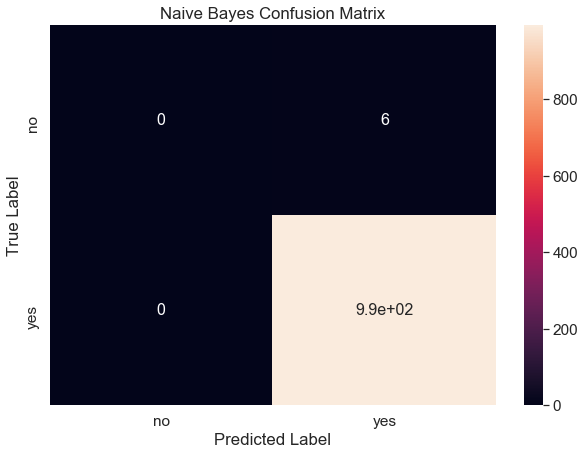

In [30]:
nb_df_cm = nb_df_cm.rename(index=str, columns={0: "no", 1: "yes"})
nb_df_cm.index = ["no", "yes"]
plt.figure(figsize = (10,7))
sn.set(font_scale=1.4)#for label size
sn.heatmap(nb_df_cm, 
           annot=True,
           annot_kws={"size": 16})

plt.title("Naive Bayes Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()